In [84]:
# data manipulation
import pandas as pd
import numpy as np

# pre processing
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

# model
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklvq import GMLVQ as BaseGMLVQ

# metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

# plotting
import matplotlib.pyplot as plt

# saving
import joblib

In [85]:
class CustomGMLVQ(BaseGMLVQ):
    def predict(self, X):
        decision_values = self.decision_function(X)
        
        if self.classes_.size == 2:
            return self.classes_[(decision_values > 0).astype(np.int64)]  # Changed from np.int to np.int64
        
        return self.classes_[decision_values.argmax(axis=1)]


In [86]:
X_train = joblib.load('data/X_train_preprocessed.pkl')
X_test = joblib.load('data/X_test_preprocessed.pkl')
y_train = joblib.load('data/y_train_preprocessed.pkl')
y_test = joblib.load('data/y_test_preprocessed.pkl')

In [87]:
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro'),
    'f1_macro': make_scorer(f1_score, average='macro')
}

In [88]:
lvq = CustomGMLVQ()
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [96]:
param_grid = [
    {
        "solver_type": ["steepest-gradient-descent", "waypoint-gradient-descent"],
        "distance_type": ["adaptive-squared-euclidean"],
        "activation_type": ["identity"],
        "solver_params": [{"step_size": s} for s in [0.1, 0.01, 0.001]]
    },
    {
        "solver_type": ["steepest-gradient-descent", "waypoint-gradient-descent"],
        "distance_type": ["adaptive-squared-euclidean"],
        "activation_type": ["sigmoid"],
        "activation_params": [{"beta": b} for b in [1, 2, 3]],
        "solver_params": [{"step_size": s} for s in [0.1, 0.01, 0.001]]
    }
]

In [97]:
def train_random_search(X, y, estimator, grid):
    random_search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=grid,
        cv=skf,
        scoring=scoring,
        refit='f1_macro',
        n_jobs=-1,
        return_train_score=True,
        n_iter=20
    )

    random_search.fit(X, y)

    return random_search

In [98]:
def get_results(r_search):
    results = pd.DataFrame(r_search.cv_results_)
    
    results = results[
        [
            'mean_fit_time', 'mean_score_time', 'param_solver_type', 'param_distance_type', 'param_activation_type',
            'param_activation_params', 'param_solver_params', 'mean_train_accuracy', 'mean_test_accuracy', 'rank_test_accuracy', 
            'mean_train_precision_macro', 'mean_test_precision_macro', 'rank_test_precision_macro', 'mean_train_recall_macro', 
            'mean_test_recall_macro', 'rank_test_recall_macro', 'mean_train_f1_macro', 'mean_test_f1_macro', 'rank_test_f1_macro'
        ]
    ]

    results = results.sort_values(by='mean_test_f1_macro', ascending=False)
    return results

In [99]:
pd.set_option('display.max_columns', None)

In [ ]:
grid_search = train_random_search(X_train, y_train, lvq, param_grid)
results = get_results(grid_search)

In [101]:
results.head(10)

,mean_fit_time,mean_score_time,param_solver_type,param_distance_type,param_activation_type,param_activation_params,param_solver_params,mean_train_accuracy,mean_test_accuracy,rank_test_accuracy,mean_train_precision_macro,mean_test_precision_macro,rank_test_precision_macro,mean_train_recall_macro,mean_test_recall_macro,rank_test_recall_macro,mean_train_f1_macro,mean_test_f1_macro,rank_test_f1_macro
16,38.713553,0.055125,waypoint-gradient-descent,adaptive-squared-euclidean,sigmoid,{'beta': 3},{'step_size': 0.01},0.739654,0.735515,15,0.659711,0.656264,14,0.768346,0.762338,2,0.664860,0.660144,1
3,37.773661,0.048429,waypoint-gradient-descent,adaptive-squared-euclidean,identity,NaN,{'step_size': 0.01},0.731431,0.729888,16,0.657697,0.655500,15,0.768733,0.763939,1,0.659418,0.656922,2
6,38.931184,0.059400,waypoint-gradient-descent,adaptive-squared-euclidean,sigmoid,{'beta': 2},{'step_size': 0.001},0.726144,0.722555,17,0.655345,0.651947,16,0.766353,0.759969,3,0.655084,0.650728,3
2,40.739431,0.060587,waypoint-gradient-descent,adaptive-squared-euclidean,identity,NaN,{'step_size': 0.001},0.726069,0.722384,18,0.655306,0.651868,17,0.766308,0.759867,4,0.655018,0.650581,4
9,38.076058,0.052093,waypoint-gradient-descent,adaptive-squared-euclidean,sigmoid,{'beta': 3},{'step_size': 0.001},0.726201,0.722384,18,0.655373,0.651868,17,0.766387,0.759867,4,0.655133,0.650581,4
0,46.494636,0.058312,waypoint-gradient-descent,adaptive-squared-euclidean,sigmoid,{'beta': 1},{'step_size': 0.001},0.726144,0.722214,20,0.655344,0.651787,19,0.766353,0.759765,6,0.655083,0.650437,6
15,38.514184,0.053042,waypoint-gradient-descent,adaptive-squared-euclidean,identity,NaN,{'step_size': 0.1},0.859406,0.847206,4,0.777100,0.730197,11,0.624655,0.600602,7,0.655978,0.623714,7
12,38.278309,0.058297,waypoint-gradient-descent,adaptive-squared-euclidean,sigmoid,{'beta': 1},{'step_size': 0.1},0.859046,0.847205,5,0.774973,0.729731,12,0.624763,0.600184,8,0.655918,0.623045,8
18,322.398568,0.054999,steepest-gradient-descent,adaptive-squared-euclidean,sigmoid,{'beta': 3},{'step_size': 0.001},0.866341,0.851977,2,0.821018,0.755483,9,0.626681,0.598463,9,0.661848,0.622104,9
4,323.581154,0.044934,steepest-gradient-descent,adaptive-squared-euclidean,sigmoid,{'beta': 2},{'step_size': 0.001},0.861471,0.852148,1,0.818905,0.781559,6,0.606360,0.582770,10,0.635934,0.602033,10


In [102]:
def view_test_metrics(train_metrics: bool, filter_top_n: int, results_df: pd.DataFrame):
    if train_metrics:
        metrics = [
            "mean_train_accuracy", "mean_test_accuracy",
            "mean_train_precision_macro", "mean_test_precision_macro",
            "mean_train_recall_macro", "mean_test_recall_macro",
            "mean_train_f1_macro", "mean_test_f1_macro"
        ]
    else:
        metrics = [
            "mean_test_accuracy",
            "mean_test_precision_macro",
            "mean_test_recall_macro",
            "mean_test_f1_macro"
        ]

    if filter_top_n:
        results_df = results_df.nsmallest(filter_top_n, "rank_test_f1_macro")

    results_df = results_df.copy()
    results_df['param_solver_params'] = results_df['param_solver_params'].astype(str)
    results_df['param_activation_params'] = results_df['param_activation_params'].astype(str)

    param_cols = ["param_solver_type", "param_distance_type", "param_activation_type", "param_activation_params", "param_solver_params"]
    plot_df = results_df.melt(
        id_vars=param_cols,
        value_vars=metrics,
        var_name="metric",
        value_name="score"
    )

    plt.figure(figsize=(12, 8))
    
    # Group the data by parameter combination and create a list of groups.
    groups = list(plot_df.groupby(param_cols))
    # Create a color palette with as many colors as there are groups.
    colors = plt.cm.tab10(np.linspace(0, 1, len(groups)))
    
    for i, (combo, group) in enumerate(groups):
        group = group.sort_values("metric")
        # Create a label for the model using its parameters.
        label_str = ", ".join(f"{col}={val}" for col, val in zip(param_cols, combo))
        # Pick the color for this group.
        color = colors[i]
        
        # Separate training and test metrics
        train_group = group[group["metric"].str.startswith("mean_train")]
        test_group = group[~group["metric"].str.startswith("mean_train")]
        
        # Plot training metrics with the same color
        if not train_group.empty:
            plt.plot(train_group["metric"], train_group["score"], 
                     marker='x', linestyle='dashed', alpha=0.7,
                     color=color,
                     label=label_str + " (train)")
        # Plot test metrics with the same color
        if not test_group.empty:
            plt.plot(test_group["metric"], test_group["score"], 
                     marker='o', linestyle='solid', alpha=0.7,
                     color=color,
                     label=label_str + " (test)")

    plt.xlabel("Metric")
    plt.ylabel("Score")
    plt.title("Comparison of Mean Test Metrics")
    plt.xticks(rotation=45)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()

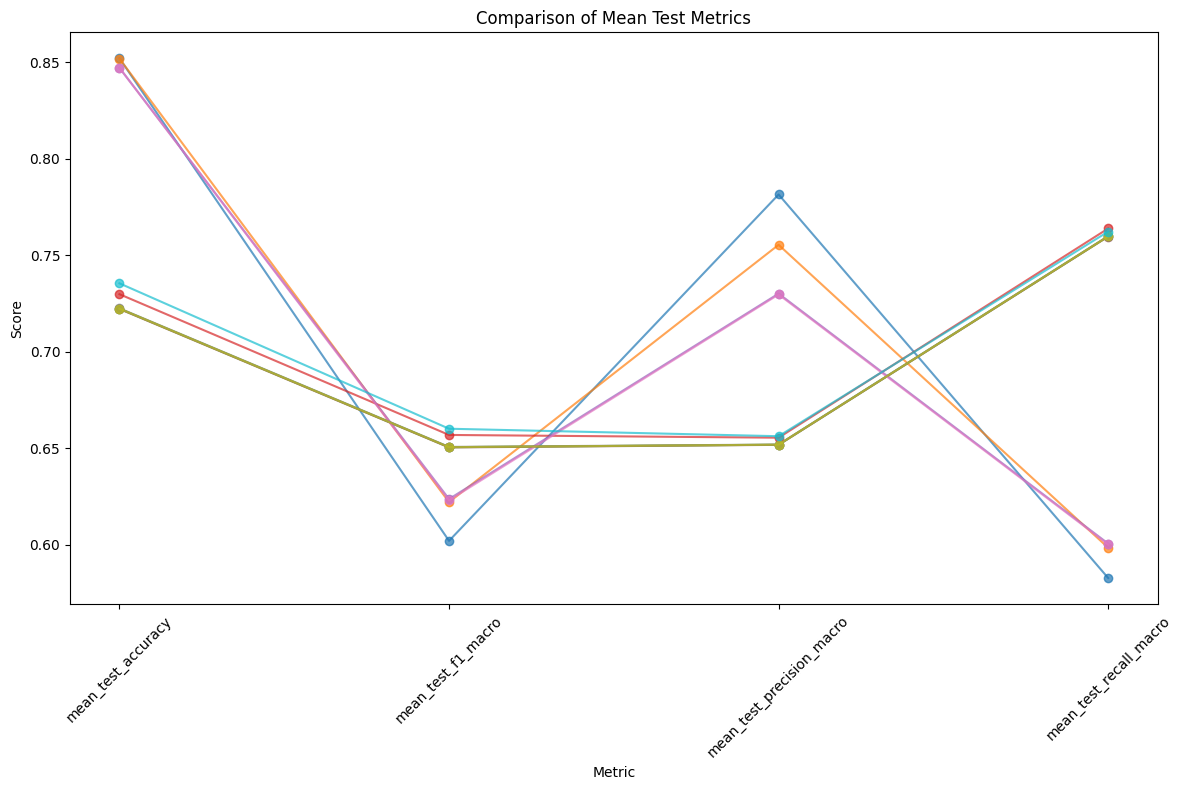

In [103]:
view_test_metrics(False, 10, results)

Como os modelos ficaram com recall e, consequentemente, f1-score baixo, isso indica que o modelo provavelmente está com bom desempenho para a classe dominante (ja que a acurácia está boa), mas não para a outra. Isso pode acontecer por conta do desbalanceamento entre as classes, então podemos tentar aplicar técnicas de balanceamento.

In [104]:
def os_smote(X, y):
    # auto faz resampling de todas as classes, menos a minoritária
    smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
    X_balanced, y_balanced = smote.fit_resample(X, y)
    
    return X_balanced, y_balanced

In [105]:
pipeline = Pipeline([
    ('oversampler', RandomOverSampler(sampling_strategy='auto', random_state=42)),
    ('lvq', CustomGMLVQ())
])

In [106]:
param_grid = [
    {
        "lvq__solver_type": ["steepest-gradient-descent", "waypoint-gradient-descent"],
        "lvq__distance_type": ["adaptive-squared-euclidean"],
        "lvq__activation_type": ["identity"],
        "lvq__solver_params": [{"step_size": s} for s in [0.1, 0.01, 0.001]]
    },
    {
        "lvq__solver_type": ["steepest-gradient-descent", "waypoint-gradient-descent"],
        "lvq__distance_type": ["adaptive-squared-euclidean"],
        "lvq__activation_type": ["sigmoid"],
        "lvq__activation_params": [{"beta": b} for b in [1, 2, 3]],
        "lvq__solver_params": [{"step_size": s} for s in [0.1, 0.01, 0.001]]
    }
]

In [107]:
def get_results_pipeline(g_search):
    results = pd.DataFrame(g_search.cv_results_)
    
    results = results[
        [
            'mean_fit_time', 'mean_score_time', 'param_lvq__solver_type', 'param_lvq__distance_type', 'param_lvq__activation_type',
            'param_lvq__activation_params', 'param_lvq__solver_params', 'mean_train_accuracy', 'mean_test_accuracy', 'rank_test_accuracy', 'mean_train_precision_macro', 
            'mean_test_precision_macro', 'rank_test_precision_macro', 'mean_train_recall_macro', 'mean_test_recall_macro', 
            'rank_test_recall_macro', 'mean_train_f1_macro', 'mean_test_f1_macro', 'rank_test_f1_macro'
        ]
    ]

    results = results.sort_values(by='mean_test_f1_macro', ascending=False)
    return results

In [114]:
def view_test_metrics_pipeline(train_metrics: bool, filter_top_n: int, results_df: pd.DataFrame):
    if train_metrics:
        metrics = [
            "mean_train_accuracy", "mean_test_accuracy",
            "mean_train_precision_macro", "mean_test_precision_macro",
            "mean_train_recall_macro", "mean_test_recall_macro",
            "mean_train_f1_macro", "mean_test_f1_macro"
        ]
    else:
        metrics = [
            "mean_test_accuracy",
            "mean_test_precision_macro",
            "mean_test_recall_macro",
            "mean_test_f1_macro"
        ]

    if filter_top_n:
        results_df = results_df.nsmallest(filter_top_n, "rank_test_f1_macro")

    results_df['param_lvq__activation_params'] = results_df['param_lvq__activation_params'].astype(str)
    results_df['param_lvq__solver_params'] = results_df['param_lvq__solver_params'].astype(str)
        
    param_cols = ["param_lvq__solver_type", "param_lvq__distance_type", "param_lvq__activation_type", "param_lvq__activation_params", "param_lvq__solver_params"]
    plot_df = results_df.melt(
        id_vars=param_cols,      # keep these columns "as is"
        value_vars=metrics,      # the columns we want to "unpivot"
        var_name="metric",       # new column with the metric name
        value_name="score"       # new column with the metric value
    )

    plt.figure(figsize=(12, 8))
    
    # Group the data by parameter combination and create a list of groups.
    groups = list(plot_df.groupby(param_cols))
    # Create a color palette with as many colors as there are groups.
    colors = plt.cm.tab10(np.linspace(0, 1, len(groups)))
    
    for i, (combo, group) in enumerate(groups):
        group = group.sort_values("metric")
        # Create a label for the model using its parameters.
        label_str = ", ".join(f"{col}={val}" for col, val in zip(param_cols, combo))
        # Pick the color for this group.
        color = colors[i]
        
        # Separate training and test metrics
        train_group = group[group["metric"].str.startswith("mean_train")]
        test_group = group[~group["metric"].str.startswith("mean_train")]
        
        # Plot training metrics with the same color
        if not train_group.empty:
            plt.plot(train_group["metric"], train_group["score"], 
                     marker='x', linestyle='dashed', alpha=0.7,
                     color=color,
                     label=label_str + " (train)")
        # Plot test metrics with the same color
        if not test_group.empty:
            plt.plot(test_group["metric"], test_group["score"], 
                     marker='o', linestyle='solid', alpha=0.7,
                     color=color,
                     label=label_str + " (test)")

    plt.xlabel("Metric")
    plt.ylabel("Score")
    plt.title("Comparison of Mean Test Metrics")
    plt.xticks(rotation=45)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()

In [ ]:
grid_search = train_random_search(X_train, y_train, pipeline, param_grid)
results = get_results_pipeline(grid_search)

In [110]:
results.head(10)

,mean_fit_time,mean_score_time,param_lvq__solver_type,param_lvq__distance_type,param_lvq__activation_type,param_lvq__activation_params,param_lvq__solver_params,mean_train_accuracy,mean_test_accuracy,rank_test_accuracy,mean_train_precision_macro,mean_test_precision_macro,rank_test_precision_macro,mean_train_recall_macro,mean_test_recall_macro,rank_test_recall_macro,mean_train_f1_macro,mean_test_f1_macro,rank_test_f1_macro
19,464.424920,0.033532,steepest-gradient-descent,adaptive-squared-euclidean,sigmoid,{'beta': 3},{'step_size': 0.001},0.780848,0.755972,1,0.692103,0.664930,1,0.811288,0.768330,1,0.708433,0.675996,1
8,59.080600,0.056033,waypoint-gradient-descent,adaptive-squared-euclidean,sigmoid,{'beta': 3},{'step_size': 0.1},0.760270,0.745920,2,0.677088,0.661041,2,0.793476,0.765638,5,0.687566,0.668485,2
0,565.322466,0.059513,steepest-gradient-descent,adaptive-squared-euclidean,sigmoid,{'beta': 1},{'step_size': 0.001},0.763131,0.744038,5,0.681035,0.660624,3,0.801098,0.766996,4,0.692019,0.667417,3
5,525.297781,0.052787,steepest-gradient-descent,adaptive-squared-euclidean,sigmoid,{'beta': 1},{'step_size': 0.01},0.762411,0.744550,4,0.677437,0.659821,5,0.792679,0.764424,7,0.688814,0.666938,4
3,530.307707,0.057038,steepest-gradient-descent,adaptive-squared-euclidean,identity,NaN,{'step_size': 0.001},0.765064,0.744723,3,0.681539,0.659548,6,0.799808,0.763666,8,0.693102,0.666749,5
6,62.139338,0.062915,waypoint-gradient-descent,adaptive-squared-euclidean,sigmoid,{'beta': 2},{'step_size': 0.1},0.755249,0.742673,6,0.674596,0.660422,4,0.791621,0.767473,3,0.683365,0.666620,6
12,63.901827,0.054720,waypoint-gradient-descent,adaptive-squared-euclidean,identity,NaN,{'step_size': 0.1},0.751610,0.737566,7,0.670730,0.658497,8,0.785292,0.765598,6,0.678708,0.662670,7
2,65.472981,0.062093,waypoint-gradient-descent,adaptive-squared-euclidean,sigmoid,{'beta': 1},{'step_size': 0.1},0.748674,0.734494,8,0.670807,0.658599,7,0.787551,0.767923,2,0.677401,0.661288,8
9,530.269960,0.055764,steepest-gradient-descent,adaptive-squared-euclidean,sigmoid,{'beta': 2},{'step_size': 0.01},0.745851,0.732783,9,0.668833,0.654166,9,0.784751,0.759420,14,0.674546,0.657239,9
4,541.603911,0.051496,steepest-gradient-descent,adaptive-squared-euclidean,sigmoid,{'beta': 3},{'step_size': 0.01},0.745320,0.731591,10,0.665837,0.650821,15,0.777233,0.751605,15,0.671830,0.653792,10


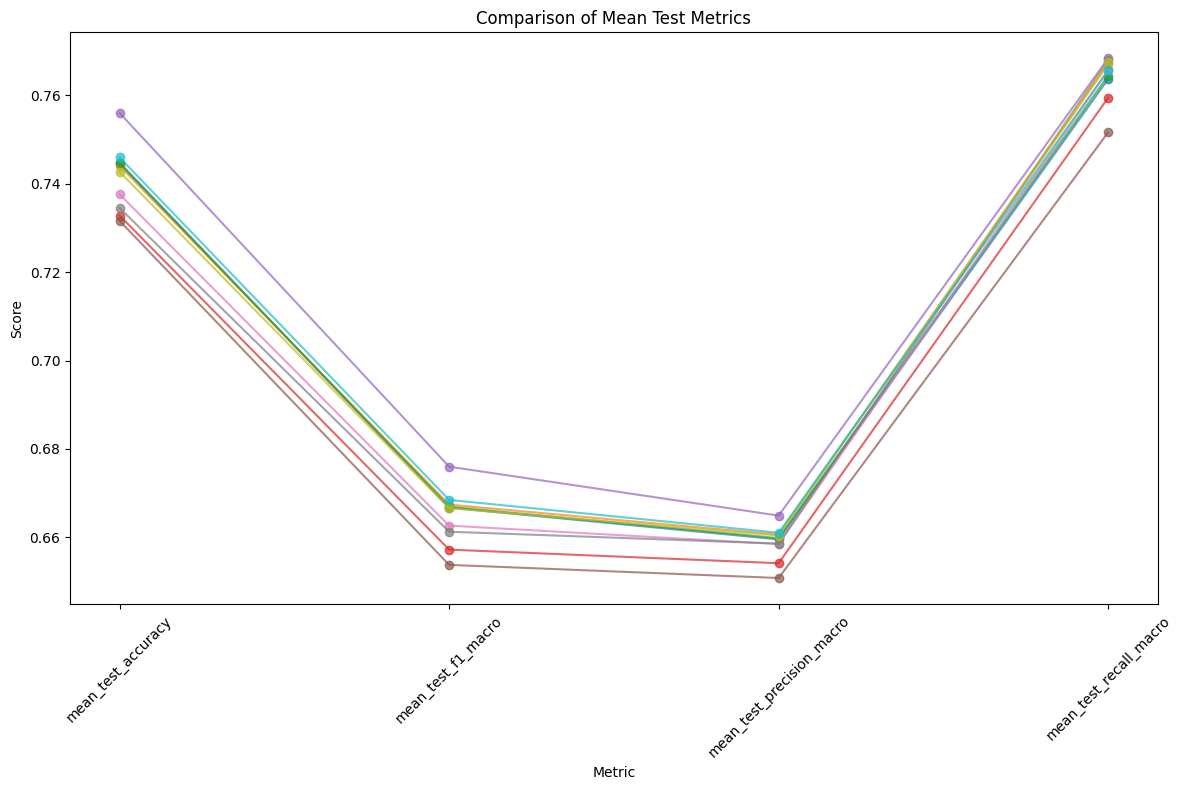

In [116]:
view_test_metrics_pipeline(False,10, results)

In [117]:
pipeline = Pipeline([
    ('oversampler', SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)),
    ('lvq', CustomGMLVQ())
])

In [ ]:
grid_search = train_random_search(X_train, y_train, pipeline, param_grid)
results = get_results_pipeline(grid_search)

In [119]:
results.head(10)



,mean_fit_time,mean_score_time,param_lvq__solver_type,param_lvq__distance_type,param_lvq__activation_type,param_lvq__activation_params,param_lvq__solver_params,mean_train_accuracy,mean_test_accuracy,rank_test_accuracy,mean_train_precision_macro,mean_test_precision_macro,rank_test_precision_macro,mean_train_recall_macro,mean_test_recall_macro,rank_test_recall_macro,mean_train_f1_macro,mean_test_f1_macro,rank_test_f1_macro
9,531.014132,0.060630,steepest-gradient-descent,adaptive-squared-euclidean,sigmoid,{'beta': 3},{'step_size': 0.001},0.782837,0.756659,1,0.691597,0.665591,2,0.808044,0.768351,3,0.708874,0.676666,1
8,538.050630,0.059594,steepest-gradient-descent,adaptive-squared-euclidean,sigmoid,{'beta': 2},{'step_size': 0.001},0.775656,0.753587,2,0.686736,0.665718,1,0.803562,0.771449,2,0.702005,0.675562,2
4,527.308768,0.053737,steepest-gradient-descent,adaptive-squared-euclidean,sigmoid,{'beta': 1},{'step_size': 0.001},0.763169,0.747280,3,0.679332,0.665278,3,0.796964,0.775184,1,0.690730,0.672470,3
0,96.657825,0.073514,waypoint-gradient-descent,adaptive-squared-euclidean,sigmoid,{'beta': 3},{'step_size': 0.1},0.759588,0.745916,4,0.675442,0.661500,4,0.790573,0.767297,5,0.686088,0.668698,4
18,496.901559,0.043020,steepest-gradient-descent,adaptive-squared-euclidean,sigmoid,{'beta': 1},{'step_size': 0.01},0.756120,0.738584,6,0.674177,0.659419,5,0.789930,0.767026,6,0.683439,0.663666,5
2,543.239905,0.060428,steepest-gradient-descent,adaptive-squared-euclidean,sigmoid,{'beta': 2},{'step_size': 0.01},0.757447,0.741826,5,0.672385,0.657178,6,0.784123,0.759863,12,0.682497,0.663497,6
7,65.905774,0.057544,waypoint-gradient-descent,adaptive-squared-euclidean,sigmoid,{'beta': 2},{'step_size': 0.1},0.739162,0.728181,8,0.666265,0.656675,7,0.783471,0.767482,4,0.669446,0.656742,7
1,90.380194,0.100314,waypoint-gradient-descent,adaptive-squared-euclidean,sigmoid,{'beta': 3},{'step_size': 0.01},0.730825,0.728350,7,0.656285,0.654010,9,0.765923,0.761358,9,0.658088,0.654911,8
17,64.500158,0.056476,waypoint-gradient-descent,adaptive-squared-euclidean,sigmoid,{'beta': 2},{'step_size': 0.01},0.730578,0.727668,9,0.655990,0.653473,10,0.765406,0.760531,11,0.657752,0.654196,9
5,61.351884,0.058009,waypoint-gradient-descent,adaptive-squared-euclidean,identity,NaN,{'step_size': 0.01},0.730218,0.727156,10,0.655637,0.653402,11,0.764821,0.760638,10,0.657318,0.653882,10


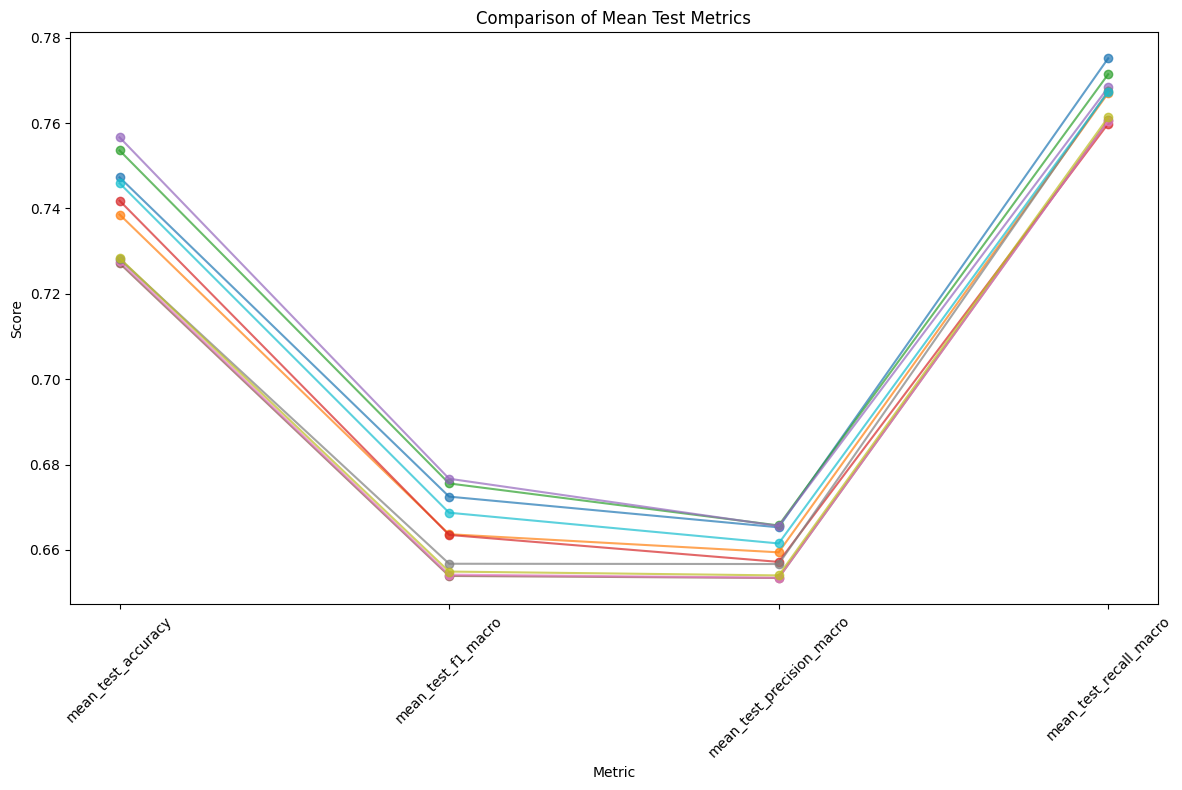

In [120]:
view_test_metrics_pipeline(False, 10, results)

In [123]:
pipeline = Pipeline([
    ('oversampler', RandomOverSampler(sampling_strategy='auto', random_state=42)),
    ('lvq', CustomGMLVQ(
        solver_type='steepest-gradient-descent',
        distance_type='adaptive-squared-euclidean',
        solver_params={'step_size': 0.001},
    ))
])

In [124]:
preds = cross_val_predict(pipeline, X_train, y_train, cv=skf, n_jobs=-1)

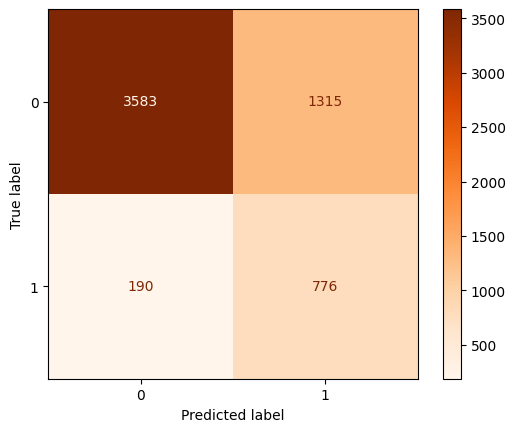

In [125]:
cm = confusion_matrix(y_train, preds)
cmd = ConfusionMatrixDisplay(cm, display_labels=grid_search.best_estimator_.classes_)
cmd.plot(cmap=plt.cm.Oranges)
plt.show()

In [126]:
print(classification_report(y_train, preds, digits=4))

              precision    recall  f1-score   support

           0     0.9496    0.7315    0.8264      4898
           1     0.3711    0.8033    0.5077       966

    accuracy                         0.7433      5864
   macro avg     0.6604    0.7674    0.6671      5864
weighted avg     0.8543    0.7433    0.7739      5864



In [127]:
joblib.dump(pipeline.named_steps['lvq'], 'models/lvq.pkl')

['models/lvq.pkl']